In [1]:
%matplotlib inline
import sys
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os, glob, math,time
import multiprocessing
import sys
sys.path.append('/home/r120084/pytorch_lib/pytorch/')


from scipy import misc
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision


import lib.pytorch_trainer as ptt

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  12



# Choose dataset 

In [3]:
path2data = "/home/e209440/data/my_distract_driver_data.npy"

# Dataset Class with split data, transformations and onehot code 

In [4]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, data_path, use_only =1.0, transforms=None, \
                 is_test=False,is_val=False,val_size=0.2):
    
        tmp_data = np.load(data_path).item()

        self.transform = transforms
        self.mlb = MultiLabelBinarizer()
        
        if is_test:
            
            length = len(tmp_data['X_test'])
            only = int(use_only * length)
            self.X = tmp_data['X_test'][:only]
            
            self.y = None #Gambiarra para poder criar DataSet do Test.
        
        else:
            
            length = len(tmp_data['X_train'])
            indices = list(range(0,length))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
            
            split = int(val_size * length)
            
            if is_val:
                self.X = [tmp_data['X_train'][i] for i in ind[:split]]
                self.y = [tmp_data['y_train'][i] for i in ind[:split]]
            else:
                self.X = [tmp_data['X_train'][i] for i in ind[split:]]
                self.y = [tmp_data['y_train'][i] for i in ind[split:]]
                
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [5]:
batch_size = 32
img_size ,img_width, img_height = 50, 50, 50
use_only = 0.1 # Use only 20% of the full dataset

labels = {  'c0' : 'safe driving', 
            'c1' : 'texting - right', 
            'c2' : 'talking on the phone - right', 
            'c3' : 'texting - left', 
            'c4' : 'talking on the phone - left', 
            'c5' : 'operating the radio', 
            'c6' : 'drinking', 
            'c7' : 'reaching behind', 
            'c8' : 'hair and makeup', 
            'c9' : 'talking to passenger'}

In [6]:
def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [7]:
# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [8]:
dsets = {
    'train': KaggleSafeDriverDataset(path2data, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [9]:
def _create_dataLoader(dsets, batch_size, cpu_count, pin_memory =  False):

    dset_loaders = {}
    for key in dsets.keys():
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, num_workers=2*cpu_count, pin_memory=pin_memory)

    return dset_loaders

In [10]:
dset_loaders = _create_dataLoader(dsets, batch_size, cpu_count)

In [11]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [12]:
def plot_classes(dset_loaders, labels, path2save = './figures/data.png'):

    # Get a batch of training data
    inputs, cls = next(iter(dset_loaders))
    print(inputs[8].shape, cls.shape)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(labels['c'+str(cls[j])]))
        plt.axis('off')
    fig.savefig(path2save)

torch.Size([3, 50, 50]) torch.Size([32])


/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


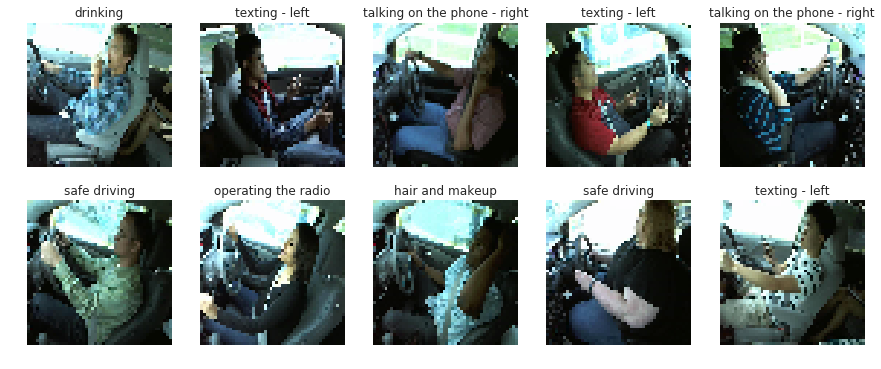

In [13]:
plot_classes(dset_loaders['train'], labels)

In [54]:
def plot_distribution(img):
    
    if img.shape[2] != 3:
        img = img.transpose((1, 2, 0))
        
    color_lst = ['red', 'green', 'blue']
    for i in range(0, img.shape[2]):
        c1=img[:,:,i].reshape(-1)
        plt.hist(c1, 50, facecolor=color_lst[i], label = color_lst[i])
    plt.legend()
    plt.grid(True)

In [65]:
def statistical_analysis_image(dset_loaders, labels, path2save = './figures/data.png'):

    
    fig = plt.figure(figsize=(15,6))
    inputs, cls = next(iter(dset_loaders))
    rand_idx = random.randrange(0, len(inputs))
    img = inputs.numpy()[rand_idx]
    img_denorm = denormalize(img)
    plt.subplot(2,2,2)
    plot_distribution(img_denorm)
    plt.title('Image RGB after denormalization')
    plt.subplot(2,2,4)
    plot_distribution(img)
    plt.title('Image RGB normalization')
    plt.subplot(1,2,1)
    img_denorm = np.clip(img_denorm, 0, 1.0)
    plt.imshow(img_denorm)
    plt.title('{}'.format(labels['c'+str(cls[rand_idx])]))
    plt.axis('off')
    fig.savefig(path2save)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


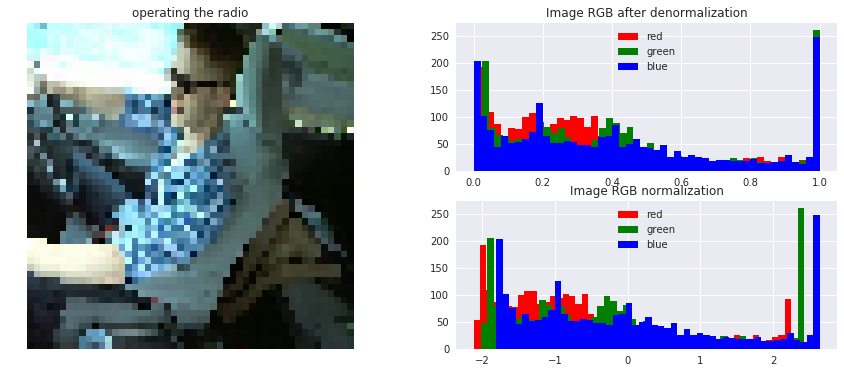

In [66]:
statistical_analysis_image(dset_loaders['train'], labels)

# Data Analysis

In [14]:
def code2label(dataset, labels): 
    class_str = []
    for item in dataset.y:
        class_str.append(labels['c'+str(item)])  
    return class_str           

In [15]:
class_str = code2label(dsets['train'], labels)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


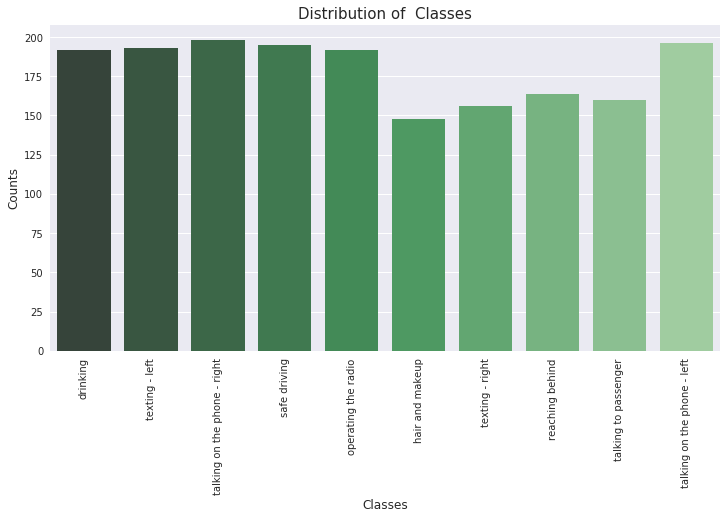

In [21]:
fig = plt.figure(figsize=(12,6))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Distribution of  Classes", fontsize=15)
plt.show()
path2save = './figures/distribution.png'
fig.savefig(path2save)

In [18]:
nb_out = len(set(class_str))

In [19]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64*3*3, out_features=100)
        self.dens2 = torch.nn.Linear(in_features=100, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

In [20]:
model = MyResNet()
if use_gpu:
    model.cuda()
    !free -h
    !nvidia-smi
    model = torch.nn.DataParallel(MyResNet())

In [21]:
print(model)

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [120]:
def predict(dset_loaders, model, get_labels = False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, (inputs, labels) in enumerate(dset_loaders):
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        
        if get_labels:
            labels_lst.append(labels)


        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'input': torch.cat(predictions, 0), 'ouput':torch.cat(labels_lst, 0) }

In [121]:
convOutput_train = predict(dset_loaders['train'], model.mrnc, get_labels= True)
convOutput_valid = predict(dset_loaders['valid'], model.mrnc, get_labels= True)

predict: 56/56 ok
predict: 13/13 ok


In [122]:
print(convOutput_train['input'].size(), convOutput_train['ouput'].size())
print(convOutput_valid['input'].size(), convOutput_valid['ouput'].size())

torch.Size([1794, 64]) torch.Size([1794])
torch.Size([448, 64]) torch.Size([448])


In [84]:
conv_dset ={
    'train': TensorDataset(convOutput_train['input'], convOutput_train['ouput']),
    'valid': TensorDataset(convOutput_valid['input'], convOutput_valid['ouput'])
} 

In [85]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, cpu_count)

In [88]:
optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [98]:
savebest = ptt.ModelCheckpoint('/home/r120084/project/models/distractdriver',reset=False, verbose=1)

params = {'model' : model.mrnd, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
        }

In [99]:
trainer = ptt.DeepNetTrainer(**params)

In [ ]:
trainer.fit_loader(20, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

In [ ]:
if use_gpu:
    !free -h
    !nvidia-smi

In [ ]:
metrics = trainer.evaluate(dset_loaders['train'])
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate(dset_loaders['valid'])
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

In [ ]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(1, 2, 1)
plt.plot([None] + trainer.metrics['train']['losses'], label='training')
plt.plot([None] + trainer.metrics['valid']['losses'], label='validation')
plt.grid()
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot([None] + trainer.metrics['train']['acc'], label='training')
plt.plot([None] + trainer.metrics['valid']['acc'], label='validation')
plt.grid()
plt.title('Accuracy')
plt.legend(loc='lower right')